<a href="https://colab.research.google.com/github/mitishasachdeva/Sentiment_Analysis_Research_Paper/blob/main/lstm_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install and import required libraries
!pip install nltk
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional

# Download NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# ✅ 1. Imports
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# NLTK setup
nltk.download('stopwords')

# ✅ 2. Load Data
columns = ["sentiment", "id", "date", "query", "user", "text"]
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', names=columns)

# ✅ 3. Keep only 'sentiment' and 'text' columns
df = df[["sentiment", "text"]]

# ✅ 4. Map sentiment to binary: 0 (negative), 4 (positive)
df = df[df["sentiment"].isin([0, 4])]
df["sentiment"] = df["sentiment"].map({0: 0, 4: 1})

# ✅ 5. Preprocessing function — as you originally wrote
def preprocess_text(text_series):
    corpus = []
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')  # 'not' is useful for sentiment

    for text in text_series:
        review = re.sub('[^a-zA-Z]', ' ', str(text))  # Remove non-letters
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in set(all_stopwords)]
        review = ' '.join(review)
        corpus.append(review)

    return corpus

# ✅ 6. Apply preprocessing CORRECTLY (on full Series)
print("Preprocessing training data...")
df["clean_text"] = preprocess_text(df["text"])

# ✅ 7. Preview
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing training data...


,sentiment,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass not behav mad see


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import pandas
import pandas as pd

# Step 3: Define the file path (adjust if it's in a subfolder)
file_path = "/content/drive/MyDrive/cleaned_twitter_sentiment.csv"

# Step 4: Load the CSV into a DataFrame
try:
    df = pd.read_csv(file_path)
    print("✅ File loaded successfully.\n")
    print(df.head())  # Show the first 5 rows
except FileNotFoundError:
    print("❌ File not found. Please check the file path and ensure it's saved in your Google Drive.")
except Exception as e:
    print(f"❌ An error occurred: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File loaded successfully.

   sentiment                                               text  \
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1          0  is upset that he can't update his Facebook by ...   
2          0  @Kenichan I dived many times for the ball. Man...   
3          0    my whole body feels itchy and like its on fire    
4          0  @nationwideclass no, it's not behaving at all....   

                                          clean_text  
0  switchfoot http twitpic com zl awww bummer sho...  
1  upset updat facebook text might cri result sch...  
2  kenichan dive mani time ball manag save rest g...  
3                    whole bodi feel itchi like fire  
4                  nationwideclass not behav mad see  


In [ ]:
# Shell: Check GPU status and install CUDA toolkit if needed
!echo "🔧 Checking GPU and CUDA setup..." && \
nvidia-smi || echo "❌ GPU not connected! Go to Runtime > Change runtime type > GPU" && \
nvcc --version || (echo "🔧 Installing CUDA toolkit..." && apt install -y cuda-toolkit-11-8 && nvcc --version)

# PyTorch CUDA Check
import torch
print("\n🚀 PyTorch CUDA Check:")
print("CUDA Available:", torch.cuda.is_available())
print("PyTorch CUDA Version:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

# TensorFlow CUDA Check
import tensorflow as tf
print("\n🚀 TensorFlow CUDA Check:")
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Available GPU Devices:", tf.config.list_physical_devices('GPU'))


🔧 Checking GPU and CUDA setup...
Mon Jun 30 05:33:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split: maintain label balance
train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['sentiment'],
    random_state=42
)


In [ ]:
# ✅ 7. Tokenization and Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Make sure NLTK stopwords are downloaded
nltk.download('stopwords')

# Parameters
MAX_WORDS = 10000
MAX_LEN = 100
text_col = "clean_text"   # 👈 make sure this column exists in both train_df and test_df
label_col = "sentiment"

# ✅ Clean the text columns: fill NaNs and convert to string
train_df[text_col] = train_df[text_col].fillna("").astype(str)
test_df[text_col] = test_df[text_col].fillna("").astype(str)

# ✅ Create and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df[text_col])

# ✅ Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df[text_col])
X_test = tokenizer.texts_to_sequences(test_df[text_col])

# ✅ Pad sequences to equal length
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

# ✅ Extract labels
y_train = train_df[label_col].values
y_test = test_df[label_col].values

# ✅ Save tokenizer to Google Drive
tokenizer_path = '/content/drive/MyDrive/tokenizer_cnn.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"✅ Tokenizer saved to: {tokenizer_path}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Tokenizer saved to: /content/drive/MyDrive/tokenizer_cnn.pkl


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
# ✅ Define model hyperparameters
vocab_size = 10000
embedding_dim = 128
input_length = 100
lstm_units = 64
rnn_units = 32
dropout_rate = 0.5

# ✅ Use plain binary labels (0 or 1)
y_train = train_df[label_col].values
y_test = test_df[label_col].values



model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    LSTM(lstm_units, return_sequences=True),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.build(input_shape=(None, input_length))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

# ✅ Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=512
)

# ✅ Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,177 (5.17 MB)

 Trainable params: 1,354,177 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - accuracy: 0.7367 - loss: 0.5208 - val_accuracy: 0.7843 - val_loss: 0.4558
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.7874 - loss: 0.4545 - val_accuracy: 0.7897 - val_loss: 0.4459
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 78s 21ms/step - accuracy: 0.7971 - loss: 0.4386 - val_accuracy: 0.7899 - val_loss: 0.4436
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - accuracy: 0.8048 - loss: 0.4239 - val_accuracy: 0.7918 - val_loss: 0.4428
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.8104 - loss: 0.4129 - val_accuracy: 0.7908 - val_loss: 0.4450
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 78s 22ms/step - accuracy: 0.8179 - loss: 0.3982 - val_accuracy: 0.7895 - val_loss: 0.4517
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 86s 24ms/step - accuracy: 0.8246 - loss: 0.3843 - val_accuracy: 0.7890 - val_loss: 0.4591
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.8308 -

In [ ]:
# 💾 Save the model
from google.colab import drive
drive.mount('/content/drive')  # run this now
model.save('/content/drive/MyDrive/lstm_cnn_model.h5')
print("Model saved as lstm_rnn_model.h5")
import pickle

# After training
with open('/content/drive/MyDrive/history_cnn.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved as lstm_rnn_model.h5


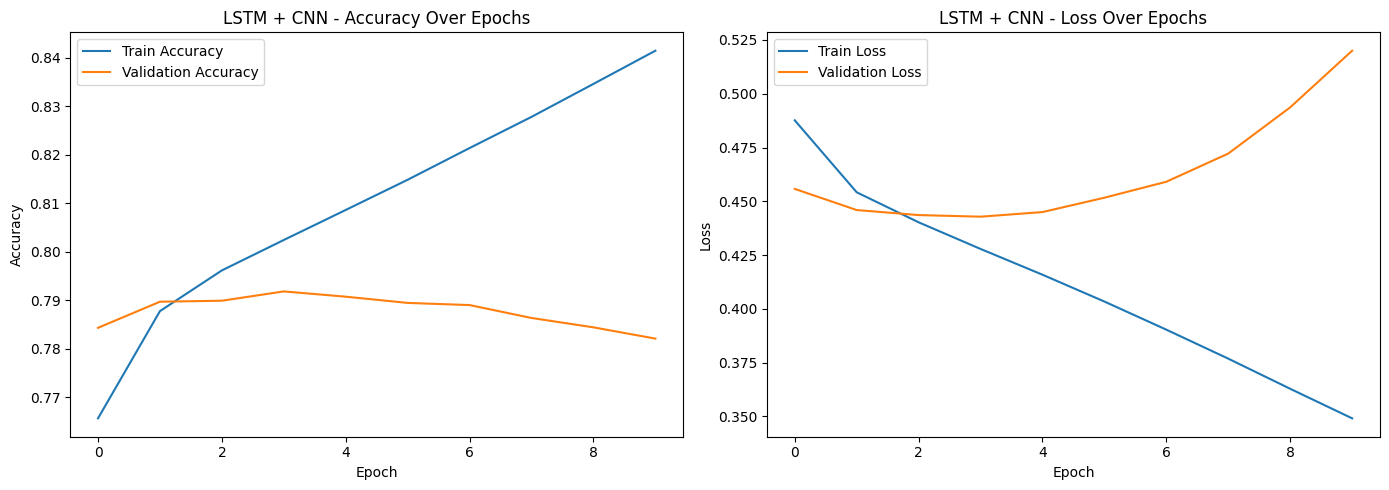

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("LSTM + CNN - Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM + CNN - Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step
              precision    recall  f1-score        support
Negative       0.787644  0.772508  0.780003  240000.000000
Positive       0.776798  0.791725  0.784190  240000.000000
accuracy       0.782117  0.782117  0.782117       0.782117
macro avg      0.782221  0.782117  0.782097  480000.000000
weighted avg   0.782221  0.782117  0.782097  480000.000000


<Figure size 800x600 with 0 Axes>

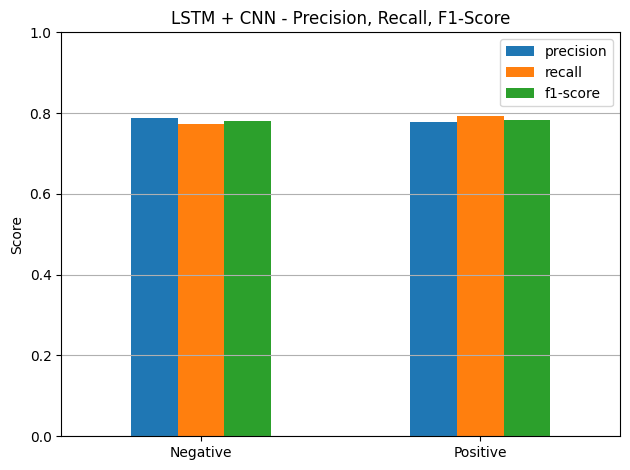

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype(int)
report = classification_report(y_test, y_pred, output_dict=True, target_names=["Negative", "Positive"])
report_df = pd.DataFrame(report).transpose()

# Display as Table
print(report_df)

# Bar chart for precision, recall, f1-score
plt.figure(figsize=(8, 6))
report_df.loc[["Negative", "Positive"]][["precision", "recall", "f1-score"]].plot(kind='bar')
plt.title("LSTM + CNN - Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


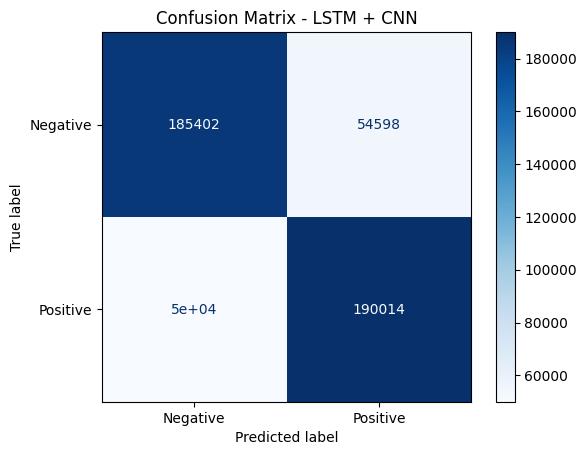

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - LSTM + CNN")
plt.grid(False)
plt.show()


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step


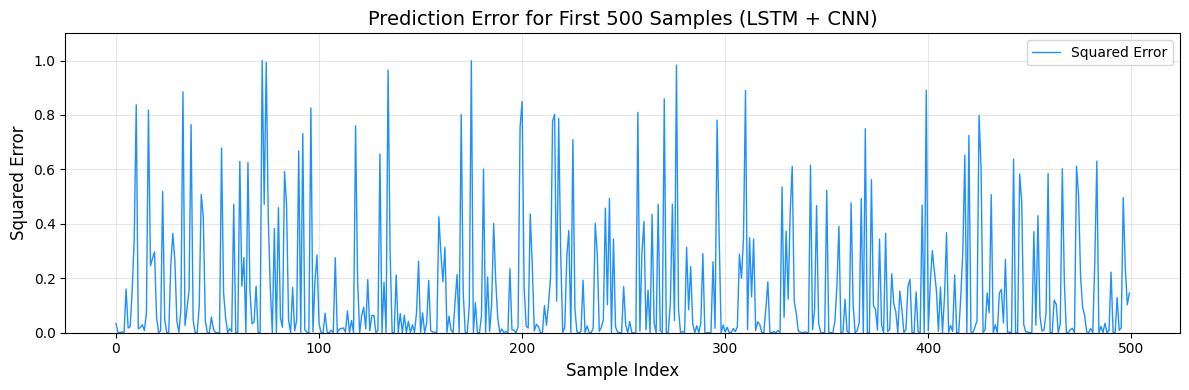

In [ ]:
import numpy as np

y_probs = model.predict(X_test).reshape(-1)
errors = np.square(y_test - y_probs)

plt.figure(figsize=(12, 4))
plt.plot(errors[:500], color='dodgerblue', label='Squared Error', linewidth=1)
plt.title("Prediction Error for First 500 Samples (LSTM + CNN)", fontsize=14)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Squared Error", fontsize=12)
plt.ylim(0, 1.1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step
✅ Accuracy  : 0.7821
🎯 Precision : 0.7768
🔁 Recall    : 0.7917
📊 F1 Score  : 0.7842
📉 RMSE      : 0.3932

📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    240000
    Positive       0.78      0.79      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



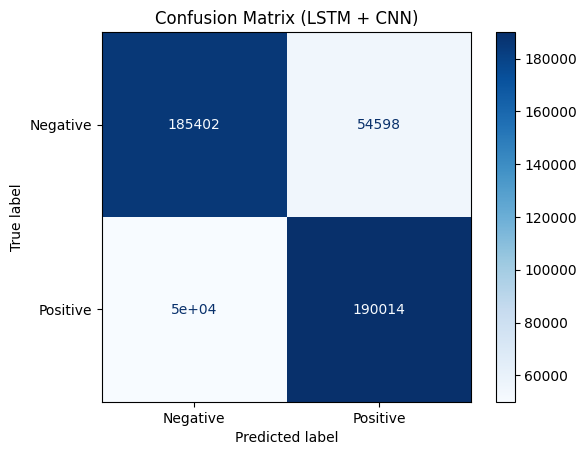

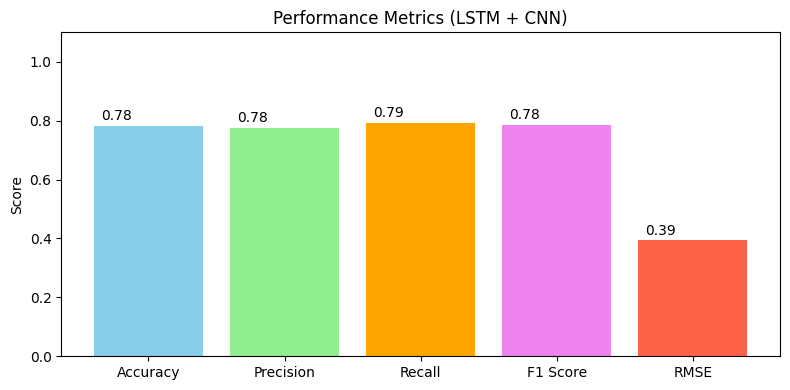

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    mean_squared_error
)

# ✅ Predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# ✅ Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_probs))

print(f"✅ Accuracy  : {acc:.4f}")
print(f"🎯 Precision : {prec:.4f}")
print(f"🔁 Recall    : {rec:.4f}")
print(f"📊 F1 Score  : {f1:.4f}")
print(f"📉 RMSE      : {rmse:.4f}")

# ✅ Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (LSTM + CNN)")
plt.grid(False)
plt.show()

# ✅ Bar Chart of Metrics
metrics = [acc, prec, rec, f1, rmse]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'RMSE']

plt.figure(figsize=(8, 4))
bars = plt.bar(labels, metrics, color=['skyblue', 'lightgreen', 'orange', 'violet', 'tomato'])
plt.title('Performance Metrics (LSTM + CNN)')
plt.ylabel('Score')
plt.ylim(0, 1.1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.05, yval + 0.02, f'{yval:.2f}', fontsize=10)
plt.tight_layout()
plt.show()
